# GitHub-Link
https://github.com/Tschoppsilas/GBSV_2025.git

## Tag 1: Muster und Algorithmus auswählen
Wählen Sie einen klassischen Bildverarbeitungs
Algorithmus zur Erkennung von Mustern wie Kanten, Linien, Kreisen oder Ecken.
Implementieren Sie jeden relevanten Schritt Ihres Mustererkennungsalgorithmus. Die
einzelnen Schritte des Algorithmus können Sie selbst programmieren oder Bibliotheken verwenden.
Wichtig ist jedoch, dass die jeweiligen Zwischenergebnisse der Schritte
in den Folgeaufgaben demonstriert werden können. Beginnen Sie ein neues Notebook.

(Ich nehme hier bereits, wie in Aufgabe 2 beschrieben ein eigenes Bild)


In [1]:
import cv2
import numpy as np


#Gauss-Filter zur Glättung (Rauschreduzierung)
def blurr(img, kernel_size=(5,5), sigma=1.4):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    return blurred

# Gradienten mit Sobel-Operator berechnen
def compute_gradient(blurred_img, ksize=3):
    sobel_x = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=ksize)
    gradient_magnitude = np.hypot(sobel_x, sobel_y)
    gradient_direction = np.arctan2(sobel_y, sobel_x)
    return gradient_magnitude, gradient_direction
    

#Non-Maximum Suppression
def non_max_suppression(magnitude, direction):
    M, N = magnitude.shape
    output = np.zeros((M,N), dtype=np.float32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # Winkelbereiche einteilen
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = magnitude[i, j+1]
                    r = magnitude[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = magnitude[i+1, j-1]
                    r = magnitude[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = magnitude[i+1, j]
                    r = magnitude[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = magnitude[i-1, j-1]
                    r = magnitude[i+1, j+1]

                if (magnitude[i,j] >= q) and (magnitude[i,j] >= r):
                    output[i,j] = magnitude[i,j]
                else:
                    output[i,j] = 0

            except IndexError as e:
                pass

    return output

#Hysterese-Schwellenwertverfahren
def hysteresis(img, low, high):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)

    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # Verbindung schwacher mit starken Kanten (8-neighbors)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if res[i,j] == weak:
                if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                    or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                    or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                    res[i,j] = strong
                else:
                    res[i,j] = 0

    return res

## Bildauswahl
Ich habe ein selbst aufgenommenes Luftbild des Brienzersees gewählt, auf dem im Vordergrund (aus der Flugrichtung gesehen) die beiden Berge Reeti und Schwarzhorn unter dem Flugzeugflügel zu erkennen sind.

Ein potenzieller Stolperstein für den Algorithmus könnte der Flügel sein – dieser ist jedoch bewusst Teil der Problemstellung: Der Algorithmus muss in der Lage sein, den Flügel klar von der Umgebung (See und Bergen) zu unterscheiden. Dies ist entscheidend, wenn das Bild als visuelle Orientierungshilfe für autonome Fluggeräte verwendet werden soll.

## Problemstellung
Bei der Analyse von Luftbildern aus kleinen Flugzeugen oder Drohnen besteht eine zentrale Herausforderung darin, relevante Landschaftsstrukturen wie Bergkämme, Uferlinien oder Täler automatisch zu erkennen – und diese klar von künstlichen Bildanteilen, wie z.B. dem Flugzeugflügel, zu trennen.

Insbesondere bei Bildern, in denen ein Teil des Flugzeugs im Bild sichtbar ist, entsteht das Problem, dass Algorithmen die klaren, geometrischen Kanten des Flügels fälschlicherweise als landschaftlich relevante Kanten interpretieren könnten.

Daher ist es notwendig, ein Verfahren zu entwickeln, das:
- natürliche Kanten (z.B. die Silhouette des Schwarzhorns oder das Seeufer)
- von künstlichen Objekten (z.B. dem Flügel oder Rumpf) automatisch unterscheidet.

Diese Trennung ist essenziell für Anwendungen wie die automatische Orientierung in Flugsystemen oder für die Erstellung verlässlicher topografischer Karten aus Luftbilddaten.

## Anwendungsfall:
In der Luftbildverarbeitung – etwa bei automatisierten Erkennungssystemen in der Kartografie oder beim 3D-Terrain-Mapping – ist die Erkennung natürlicher Kanten (Bergrücken, Gewässergrenzen, Talverläufe) ein zentraler erster Verarbeitungsschritt.

Die extrahierten Informationen können genutzt werden, um:
- Geländeformen zu analysieren
- Höhenprofile zu rekonstruieren
- visuelle Orientierungshilfen für autonome Fluggeräte zu erstellen – insbesondere zur Trennung von fixen Teilen des Fluggeräts (wie dem Flügel) und der Umwelt.

## Warum dieses Bild?
Das Bild bietet eine realistische und komplexe Szene mit vielfältigen Merkmalen:
- Der Flügel als künstliches Objekt mit klaren Kanten
- Der See als homogene Fläche mit deutlicher Uferlinie
- Die Berglandschaft mit unregelmässigen, natürlichen Konturen

Diese Vielfalt macht das Bild ideal zur Demonstration der Schritte eines Mustererkennungsalgorithmus wie dem Canny-Kantendetektor – von der Rauschunterdrückung bis zur finalen Kantenauswahl.

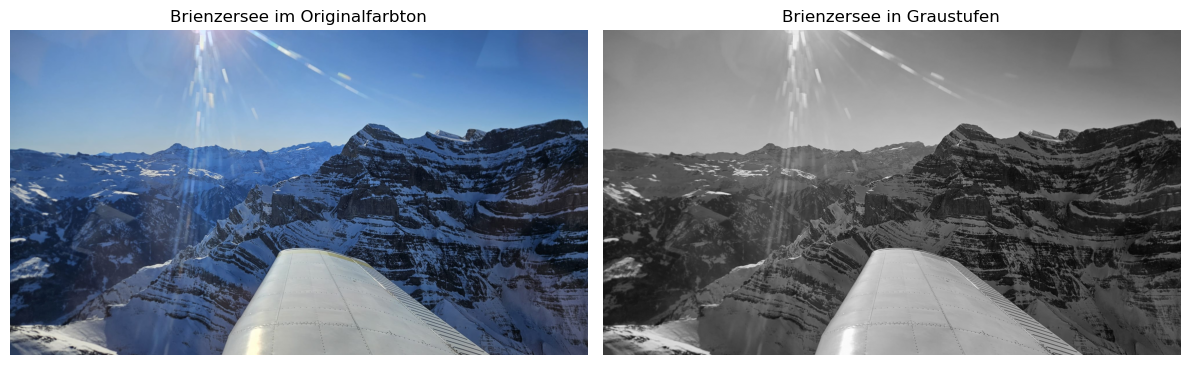

In [24]:
import cv2
import matplotlib.pyplot as plt

# Bild laden (Original und Graustufen)
#img_color = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Brienzersee.jpg")
img_color = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Berg_bei_glarus.jpg")
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Anzeigen der Bilder nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Originalbild anzeigen
axes[0].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
axes[0].set_title('Brienzersee im Originalfarbton')
axes[0].axis('off')  # Achsen ausblenden

# Graustufenbild anzeigen
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Brienzersee in Graustufen')
axes[1].axis('off')  # Achsen ausblenden

# Anzeigen der Bilder
plt.tight_layout()
plt.show()

# Tag 3

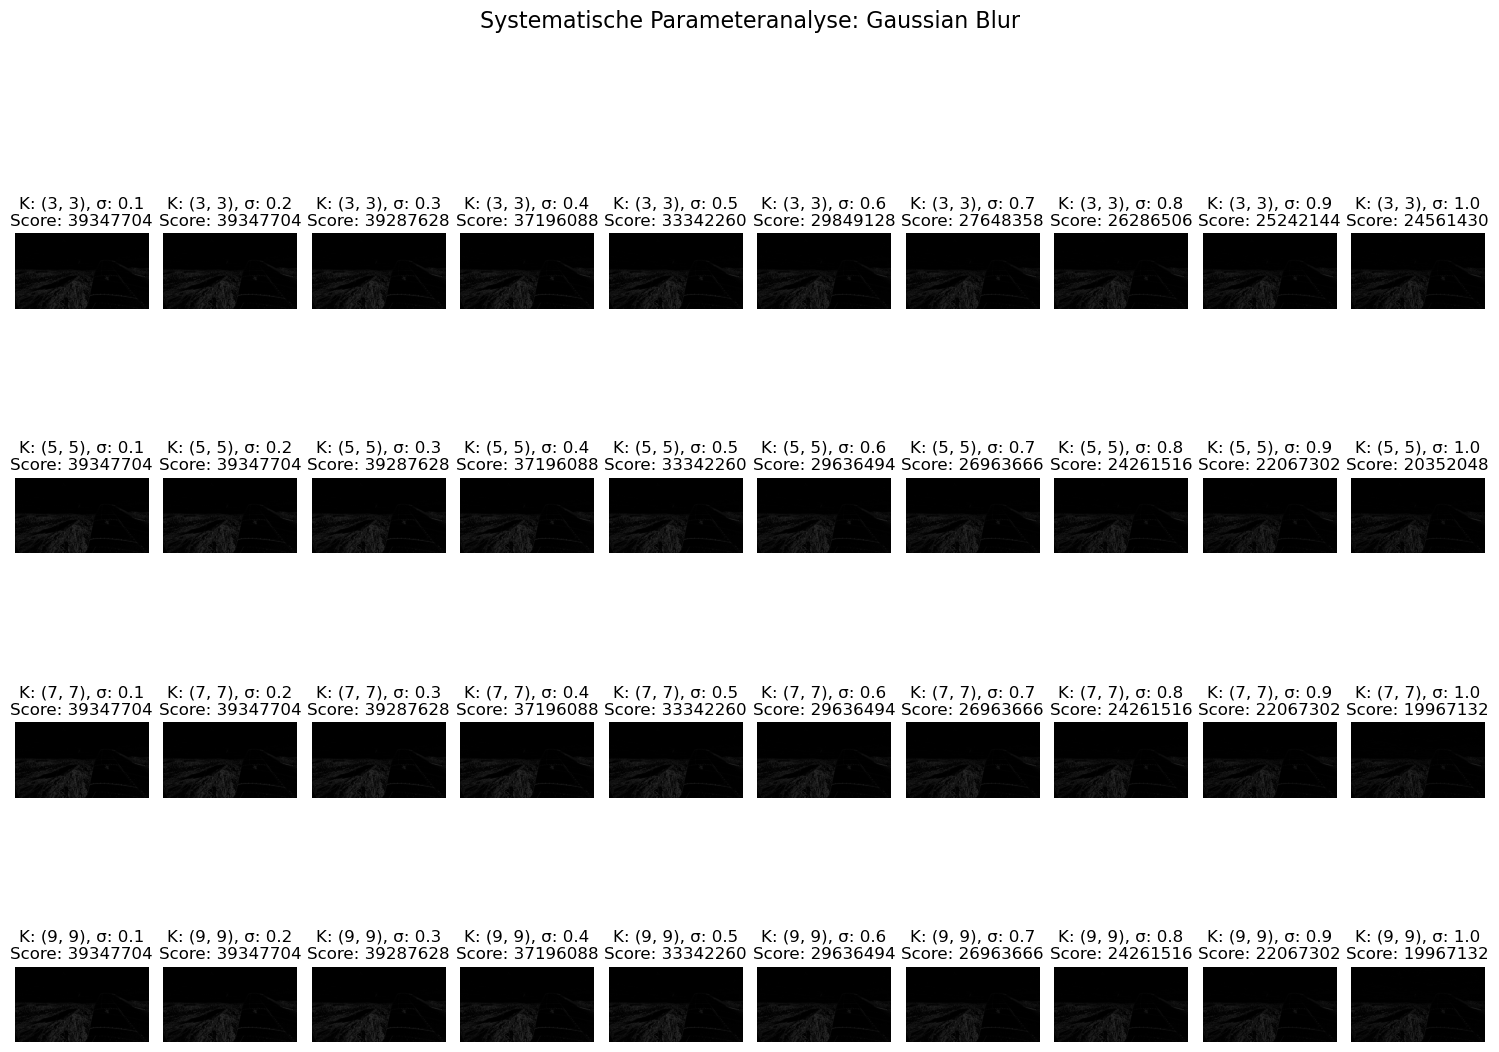

In [19]:
import numpy as np
# Nur gültige Kernelgrössen verwenden (ungerade)
kernel_sizes = [(3,3), (5,5), (7,7), (9,9)]
sigmas = np.linspace(0.1, 1.0, 10)

# Speichern der besten Kombination
best_score = -np.inf
best_combo = None
best_img = None

# Visualisierung
fig, axs = plt.subplots(len(kernel_sizes), len(sigmas), figsize=(15, 12))
fig.suptitle("Systematische Parameteranalyse: Gaussian Blur", fontsize=16)

for i, ksize in enumerate(kernel_sizes):
    for j, sigma in enumerate(sigmas):
        blurred = blurr(img, kernel_size=ksize, sigma=sigma)
        grad_mag, grad_dir = compute_gradient(blurred)
        suppressed = non_max_suppression(grad_mag, grad_dir)

        # Bewertung: Summe der Kantenschärfe
        score = np.sum(suppressed)
        if score > best_score:
            best_score = score
            best_combo = (ksize, sigma)
            best_img = suppressed

        # Darstellung im Grid
        axs[i, j].imshow(suppressed, cmap="gray")
        axs[i, j].set_title(f"K: {ksize}, σ: {sigma:.1f}\nScore: {score:.0f}")
        axs[i, j].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

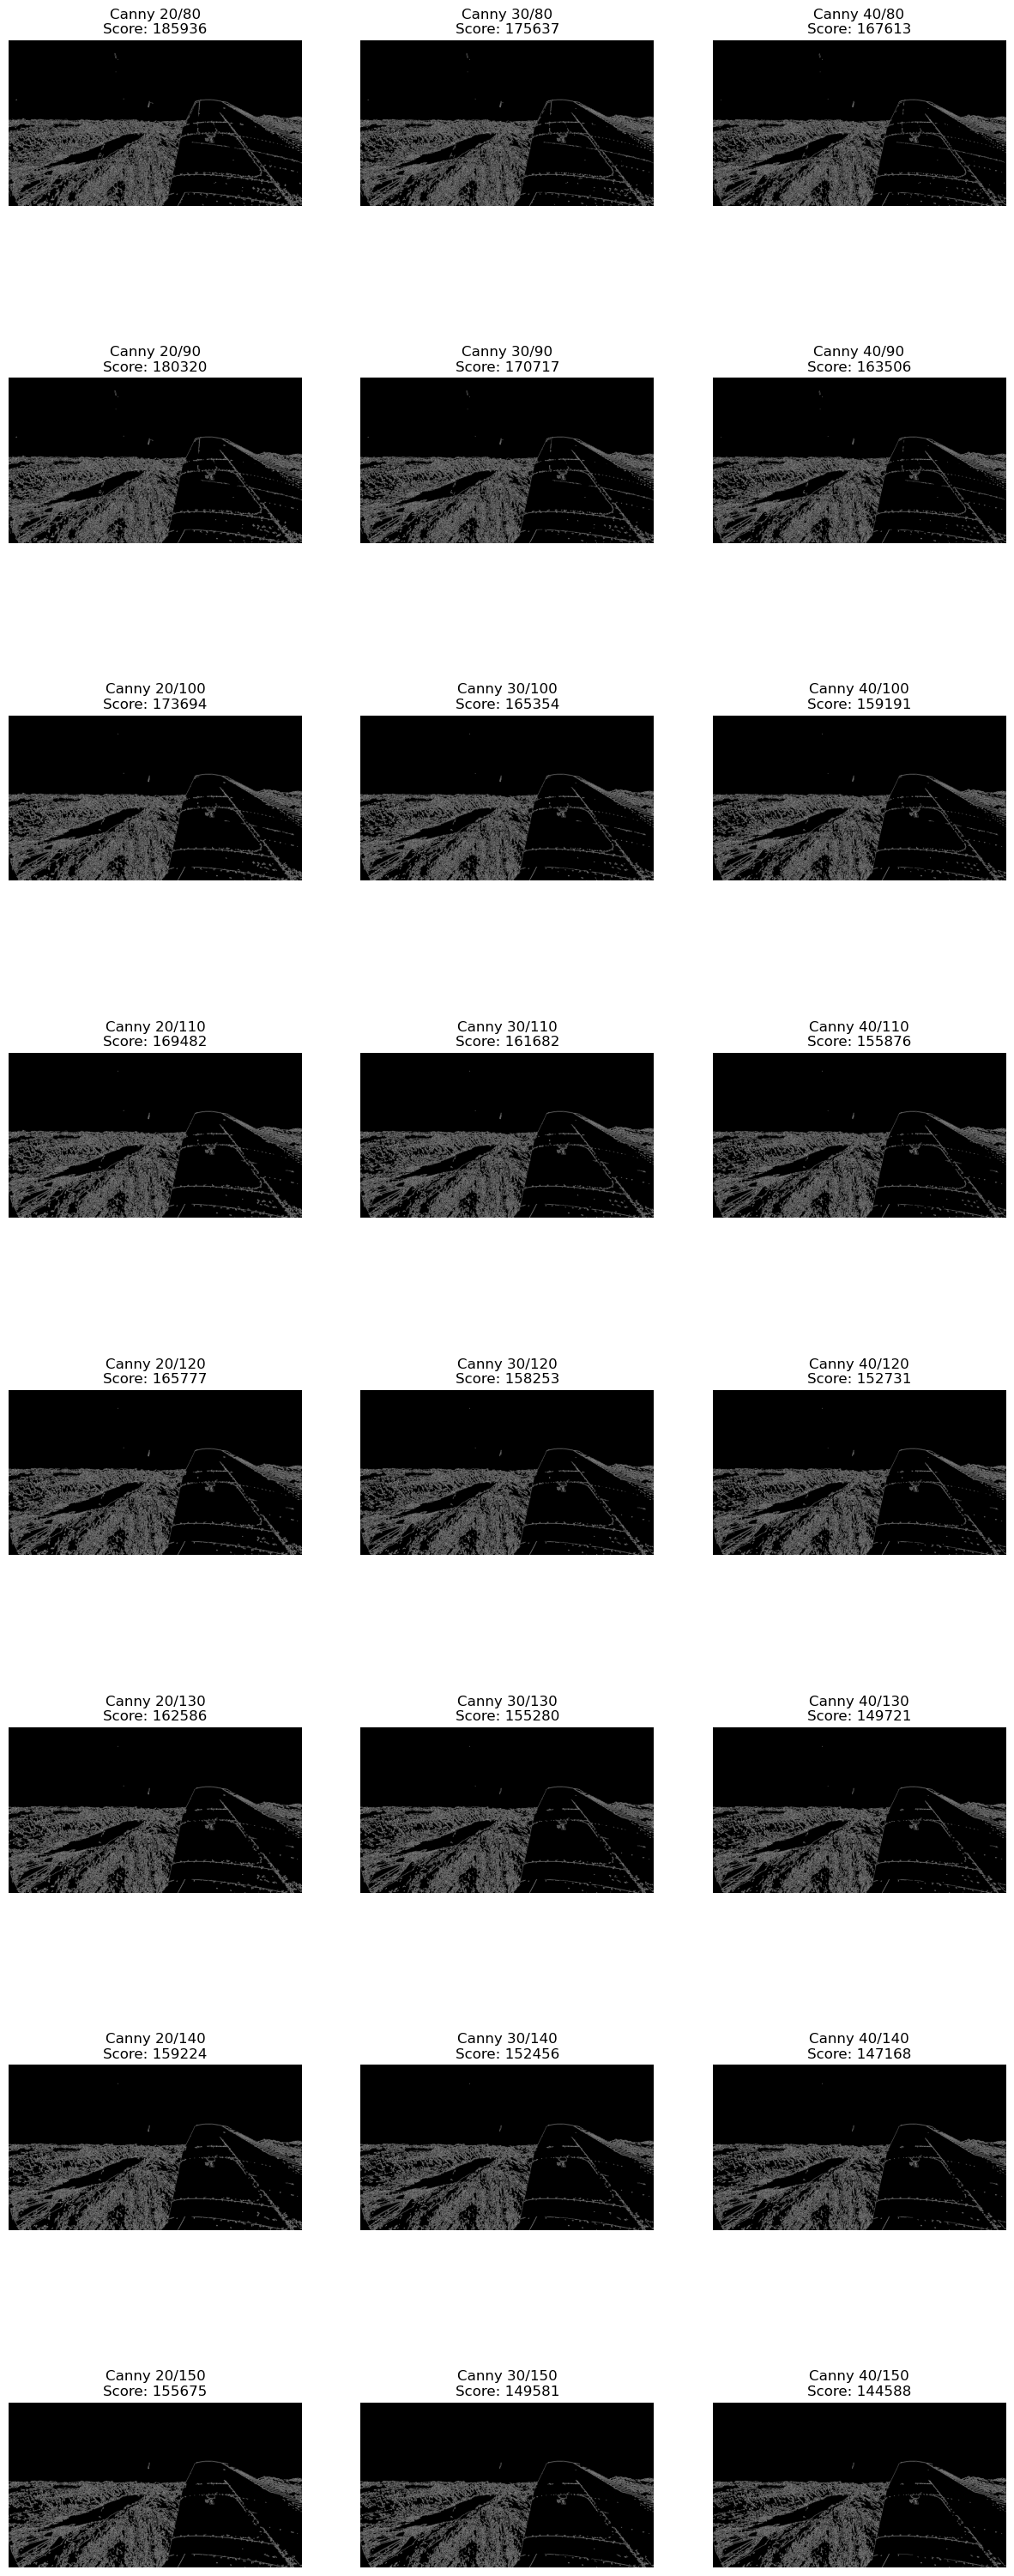

In [22]:
# Bild glätten
blurred = cv2.GaussianBlur(img, (3,3), 0.2)

# Schwellenwerte systematisch durchlaufen
low_values = [20, 30, 40]
high_values = [80, 90, 100, 110, 120, 130, 140, 150]

best_score = -np.inf
best_thresh = None
best_edges = None

cols = 3
rows = int(np.ceil((len(low_values) * len(high_values)) / cols))
plt.figure(figsize=(5 * cols, 5 * rows))

idx = 1

for high in high_values:
    for low in low_values:
        if low >= high:
            continue
        edges = cv2.Canny(blurred, low, high)

        # Bewertung: viele Kanten, wenig Rauschen
        edge_pixels = np.sum(edges > 0)
        noise_penalty = np.sum(edges == 255) * 0.1  # Rauschen leicht bestrafen
        score = edge_pixels - noise_penalty

        if score > best_score:
            best_score = score
            best_thresh = (low, high)
            best_edges = edges

        # Plot
        plt.subplot(rows, cols, idx)
        plt.imshow(edges, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Canny {low}/{high}\nScore: {score:.0f}")
        plt.axis('off')
        idx += 1

## Erkenntis zum Threshold-Wert für die Kanntenerkennung
Zur objektiven Bewertung der Schwellenwerte im Canny-Kantendetektor habe ich verschiedene Kombinationen getestet und visuell verglichen. Die Ergebnisse zeigen deutlich, wie stark sich die Wahl der Parameter auf die Qualität der Kantenextraktion auswirkt.

Bei niedrigen Werten (z.B. low=20, high=80) erkennt der Algorithmus eine Vielzahl an feinen Kanten. Diese hohe Sensitivität führt zwar zur Erfassung vieler Details – etwa der Berghänge und der Uferlinie – allerdings auch zu einem hohen Mass an Bildrauschen. Insbesondere die homogene Wasserfläche und der Himmelbereich tragen in diesen Fällen unnötige Kantenartefakte bei, was die Trennung relevanter Strukturen erschwert.

Hohe Schwellenwertpaare (z.B. 40/130 oder 30/150) liefern dagegen deutlich selektivere Ergebnisse. Hier werden fast ausschliesslich sehr starke Kanten erkannt – vor allem die Kontur des Flugzeugflügels – während feinere Landschaftsmerkmale wie Bergsilhouetten oder Seeufer teilweise verloren gehen. Diese Parameter sind daher für Anwendungen, bei denen Landschaftsstrukturen im Vordergrund stehen, nur bedingt geeignet.

Die Kombination 20/90 erwies sich als besonders ausgewogen: Der Flugzeugflügel wird zuverlässig und klar abgegrenzt, ohne dass natürliche Strukturen wie Bergkämme oder Uferlinien unterdrückt werden. Gleichzeitig bleibt das Rauschniveau moderat, was die Interpretation der Szene erleichtert. Damit erfüllt diese Einstellung die zentralen Anforderungen der Problemstellung und eignet sich hervorragend für den geplanten Anwendungsfall – etwa als Grundlage für visuelle Orientierungssysteme in autonomen Fluggeräten.



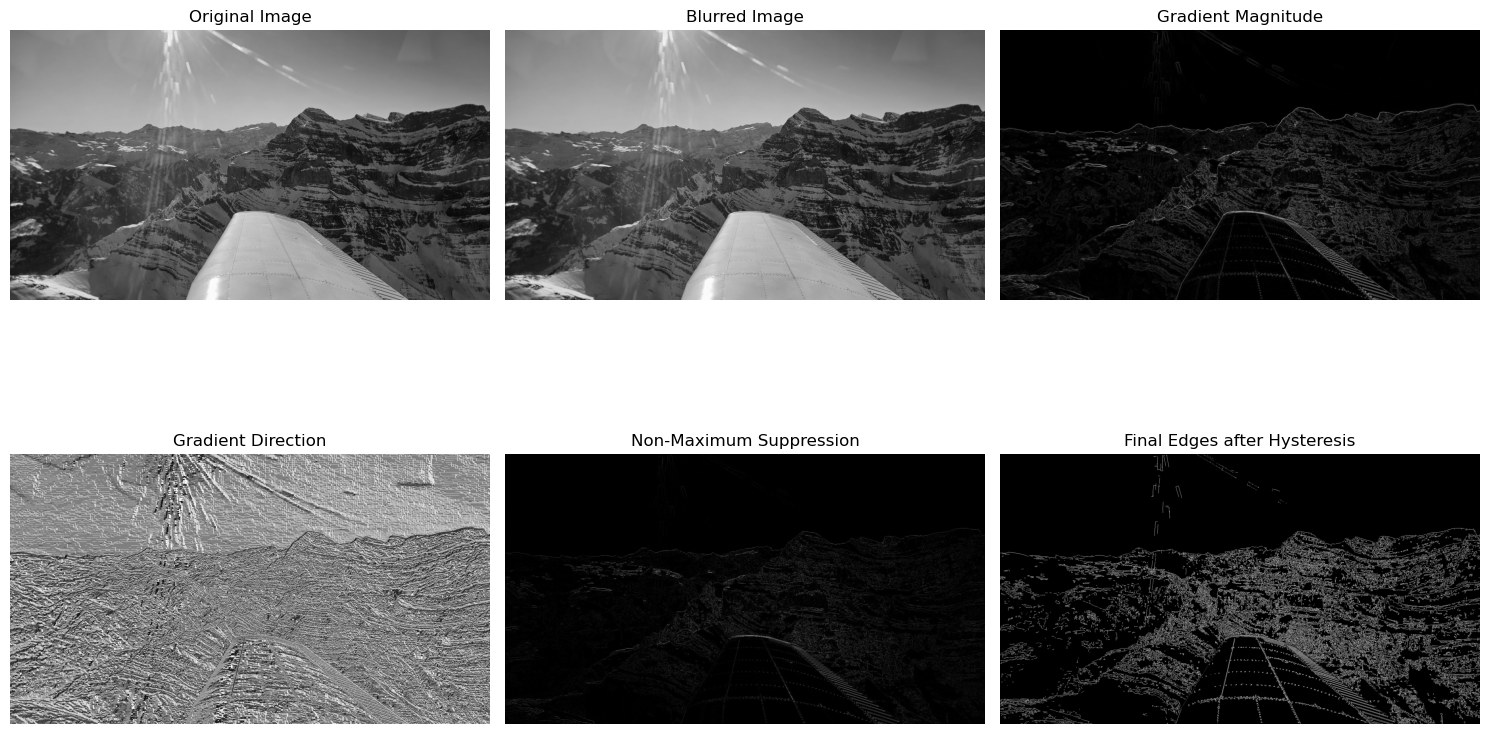

In [25]:
blurred = blurr(img, (3, 3), 0.2)
magnitude, direction = compute_gradient(blurred)
nms_result = non_max_suppression(magnitude, direction)
final_edges = hysteresis(nms_result, low=20, high=80)

# --- Ergebnisse plotten ---
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(direction, cmap='gray')
plt.title('Gradient Direction')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(nms_result, cmap='gray')
plt.title('Non-Maximum Suppression')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(final_edges, cmap='gray')
plt.title('Final Edges after Hysteresis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Tag 4: Ergebnisse der Mustererkennung – Diskussion und Bewertung
Für die Mustererkennung habe ich den Canny-Edge-Detection-Algorithmus gewählt, da er sich besonders gut für Szenen eignet, in denen sowohl feine als auch dominante Kanten präzise extrahiert werden sollen. Dieses Verfahren bietet eine mehrstufige Verarbeitung, die durch Rauschunterdrückung, Gradientenberechnung, Nicht-Maximale-Suppression und Doppelschwellenwert-Filterung robuste Ergebnisse ermöglicht. Meine Wahl fiel auf Canny, weil sich der Algorithmus hervorragend zur Trennung von natürlichen Landschaftsstrukturen und technischen Elementen wie dem Flugzeugflügel eignet, was ein zentrales Ziel meiner Problemstellung ist.

Wie bereits in Tag 3 erwähnt, habe verschiedene Parameterpaare getestet (z.B. low=20, high=80 bis 40/130) und deren Auswirkungen auf die Kantendetektion visuell ausgewertet. Die Kombination 20/90 erwies sich als optimal: Der Flügel wird klar abgegrenzt, ohne dabei feine Merkmale wie die Bergsilhouetten oder das Seeufer zu verlieren. Diese Ergebnisse erfüllen die Anforderung, relevante natürliche Strukturen für visuelle Navigationssysteme in autonomen Fluggeräten zuverlässig zu extrahieren und dabei künstliche Objekte wie Flugzeugteile zu isolieren.

Die Wahl der Parameter basiert auf dem Ziel, ein Gleichgewicht zwischen Kantenempfindlichkeit und Rauschunterdrückung zu erzielen. Niedrigere Thresholds führten zu zuviel Rauschen (vor allem im Himmel/Wasser), höhere zu Informationsverlust. Der getestete Mittelwert bot für mich den besten Kompromiss.

Meine Visualisierungen zeigen exemplarisch die Auswirkungen der Schwellenwerte auf die Kantenerkennung im selbst gemachtem Luftbild des Brienzersees (Kanton Bern). Die Umrisse von Reeti (Berg zwischen Grindelwald und Brienzersees) und die Uferlinie des Sees werden bei optimalen Einstellungen gut hervorgehoben, während der Flügel als technisches Objekt zuverlässig isoliert bleibt.

# Überarbeitung (322 Wörter)
Für die Mustererkennung kam der Canny-Edge-Detection-Algorithmus zum Einsatz, da er sich durch eine robuste mehrstufige Kantenextraktion auszeichnet (Rauschreduktion, Gradientenberechnung, nicht-maximale Unterdrückung, doppelte Schwellenwertprüfung). Canny eignet sich besonders gut zur Trennung von natürlichen Strukturen (z.B. Landschaft, Seeufer, Berge) und technischen Objekten (z.B. Flugzeugflügel) – ein zentrales Ziel meiner Problemstellung im Kontext visueller Navigation autonomer Luftfahrzeuge in den Schweizer Bergen.

Ich habe systematisch verschiedene Threshold-Kombinationen getestet (z.B. low = 20–40, high = 80–150). Als optimal erwies sich die Kombination 20/90: Sie ermöglicht eine klare Abgrenzung des Flugzeugflügels, ohne feine Konturen wie Bergsilhouetten oder die Uferlinie des Brienzersees zu verlieren. Schwellenpaare mit höheren Werten führten zu Informationsverlust; niedrigere wiederum verstärkten das Bildrauschen, insbesondere in homogenen Bildbereichen wie Himmel und Wasser.

Diese Parameterwahl basiert auf dem Ziel, ein gutes Gleichgewicht zwischen Kantenempfindlichkeit und Rauschunterdrückung herzustellen – entscheidend für die Erkennung relevanter Navigationsstrukturen bei gleichzeitiger Isolierung technischer Bildbestandteile.

Die zugehörigen Visualisierungen zeigen, wie sich die Schwellenwertwahl auf die Kantenextraktion auswirkt. Besonders hervorzuheben sind die klar konturierten Umrisse des Reeti-Massivs sowie die Uferlinie des Sees, während der Flügel als technisches Objekt konsistent isoliert bleibt. Die Analyse offenbart zudem, dass bereits geringe Änderungen der Parameter signifikante Auswirkungen auf die Kantenschärfe und Vollständigkeit haben – ein Aspekt, der für adaptive Bildverarbeitungssysteme von Bedeutung ist.

Zusätzlich zur Anwendung des OpenCV-internen Canny-Operators habe ich zentrale Verfahrensschritte eigenständig implementiert, um ein vertieftes Verständnis des Algorithmus zu entwickeln und gezielter Einfluss auf die Kantenextraktion zu nehmen:
- Rauschunterdrückung: mittels eines anpassbaren Gaussian Blur zur Glättung.
- Gradientenberechnung: mit dem Sobel-Operator in x- und y-Richtung zur Ermittlung von Kantenstärke und -richtung.
- Nicht-Maximale Suppression: zur gezielten Verdünnung der Kanten auf lokales Maximum.
- Hysterese-Schwellenwertverfahren: zur Verbindung schwacher mit starken Kanten – unter Verwendung adaptiver Threshold-Werte.

Diese modulare Implementierung erlaubt eine feinere Kontrolle der Parameter und ein besseres Verständnis für deren Auswirkungen. Im Gegensatz zur "Black-Box"-Verwendung in OpenCV konnte ich so etwa den Einfluss der Kantenausrichtung oder die Reaktion auf unterschiedliche Gradientenstärken direkt nachvollziehen und debuggen.